## Data preparation swissgeol.ch and map.geo.admin.ch

# Borehole data

#### Editor: ON; Date: 10.11.2020

### Background
Borehole data from borehole database have to be integrated nto map.geo.admin.ch and swissgeol.ch simultaniously.
Data preparation is performed using this skript.

#### Prodecdure
1. Export data on layer basis from GeODin (not part of this skript)
2. Import data to DataFrame
3. Convert DataFrame to GeoDataFrame
4. Check for duplicated rows and delete them
5. Check for spatial outline (data not located in CH) and clip to Swiss boundary
6. Sort data according to Borehole identifier and Depth of layers
7. Select relevant attributes
8. ...

 
#### Output:
* 2D dataset containing all boreholes as 2D point geometry and selected attributes
* public 3D dataset containg all boreholes on a layer basis; individual layers of restricted boreholes are combined to one single layer (*DEPTHTO* = *LENGTH*)
* private 3D dataset containg all boreholes on a layer basis; individual layers of restricted boreholes are preserved

#### Directory structure:
* **Root:**
    * Directory named as you like, e.g.: `Dataprepration`, all magic is going on inside here!
* **Input:** 
    * Borehole data: `./data/input/bh/`
    * Helper files: `./data/input/helper/`
    
* **Output:**    
    * All output of specific run at a given date, e.g.: `./data/output/run_20201110_01` following the Template `_TEMPLATE_run_YYYYMMDD_00`
    * Log file of the given run: `log_run_20201110_01`


#### User Input

User input is marked by <h3><font color='red'>red</font> text</h3>

User input is required for:
* Number of run. Spefify the number of the current run
* Root directory. The Root path, the location where all input and output data is stored, may be defined by the user. By default the present working direktory, i.e. the directory where this notebook is located, is defined as root directory 
* Inspecting data
* [Exporting data](#linkxy)

In [1]:
# Import libraries
import os
import datetime
import pandas as pd
import numpy as np
import glob
import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl 
import matplotlib.pyplot as plt

# Import 'little helpers' for convenience
import onUtils



<font color=red><h1>
User Input >>>>></h1></font>

In [2]:
# USER input required
# >>>>
#run_num = input("Enter run number (0-99):")
run_num = 0

# Root directory
root_dir = %pwd

# >>>>
#root_dir = '/Users/oesterli/Desktop/python_space/'


<a id="linkConfig"></a>
<font color=blue><h1>
    Configuration >>>>></h1></font> 

In [3]:
# input
## input directory for borhole data
in_dir_bh = os.path.join(root_dir, 'data/input/bh')

## input directory for helper files
in_dir_hp = os.path.join(root_dir,'data/input/helper')
in_dir_hp

# output
## timestamp for out_dir
now = datetime.datetime.now().strftime('%Y%m%d')

## Convert number of run (run_num) to two digit str
run_dir = '_'.join(['run',now,str(run_num).zfill(2)])

## Define output directory path
out_dir_run = os.path.join(root_dir,'data/output',run_dir)

## check if out_dir already exists
if os.path.isdir(out_dir_run):
    print('ok! Out directory already exists.')
else:
    print('Output directory not existing, directory will de created')
    os.mkdir(out_dir_run)
    
# Define name of log-file
log_name = 'test_log'

# Define columns to select
sel_cols = ["index", "XCOORD","YCOORD","ZCOORDB","ORIGNAME","NAMEPUB",
            "SHORTNAME", 'BOHREDAT',"BOHRTYP", 'GRUND',"RESTRICTIO",
            "TIEFEMD","DEPTHFROM","DEPTHTO",'LAYERDESC','ORIGGEOL',"LITHOLOGY", 
            "LITHOSTRAT", 'CHRONOSTR', 'TECTO', 'USCS1', 'USCS2', 'USCS3']

sel_cols_2 = ["XCOORD","YCOORD","ZCOORDB","ORIGNAME","NAMEPUB","SHORTNAME", 
              'BOHREDAT','GRUND',"RESTRICTIO","TIEFEMD","DEPTHFROM","DEPTHTO",'LAYERDESC']

# Original column names for 3D
cols_pub = ['index', 'XCOORD', 'YCOORD', 'ZCOORDB', 'ORIGNAME', 'NAMEPUB',
       'SHORTNAME', 'BOHREDAT', 'BOHRTYP', 'GRUND', 'RESTRICTIO', 'TIEFEMD',
       'DEPTHFROM', 'DEPTHTO', 'LAYERDESC', 'ORIGGEOL', 'LITHOLOGY',
       'LITHOSTRAT', 'CHRONOSTR', 'TECTO', 'USCS1', 'USCS2', 'USCS3',
       'geometry','geom4326', 'x4326', 'y4326']

# Columns names for 3D export
export_pub_cols = ["bh_pub_index", "bh_pub_XCOORD","bh_pub_YCOORD","bh_pub_ZCOORDB",
                   "bh_pub_ORIGNAME","bh_pub_NAMEPUB","bh_pub_SHORTNAME", 
                   'bh_pub_BOHREDAT',"bh_pub_BOHRTYP", 'bh_pub_GRUND',"bh_pub_RESTRICTIO",
                   "bh_pub_TIEFEMD","bh_pub_DEPTHFROM","bh_pub_DEPTHTO",'bh_pub_LAYERDESC',
                   'bh_pub_ORIGGEOL',"bh_pub_LITHOLOGY", "bh_pub_LITHOSTRAT", 
                   'bh_pub_CHRONOSTR', 'bh_pub_TECTO', 'bh_pub_USCS1', 'bh_pub_USCS2', 
                   'bh_pub_USCS3','bh_pub_geometry', 'bh_pub_geom4326', 'bh_pub_x4326', 
                   'bh_pub_y4326']

export_pri_cols = ["bh_pri_index", "bh_pri_XCOORD","bh_pri_YCOORD","bh_pri_ZCOORDB",
                   "bh_pri_ORIGNAME","bh_pri_NAMEPUB","bh_pri_SHORTNAME", 
                   'bh_pri_BOHREDAT',"bh_pri_BOHRTYP", 'bh_pri_GRUND',"bh_pri_RESTRICTIO",
                   "bh_pri_TIEFEMD","bh_pri_DEPTHFROM","bh_pri_DEPTHTO",'bh_pri_LAYERDESC',
                   'bh_pri_ORIGGEOL',"bh_pri_LITHOLOGY", "bh_pri_LITHOSTRAT", 
                   'bh_pri_CHRONOSTR', 'bh_pri_TECTO', 'bh_pri_USCS1', 'bh_pri_USCS2', 
                   'bh_pri_USCS3','bh_pri_geometry', 'bh_pri_geom4326', 'bh_pri_x4326', 
                   'bh_pri_y4326']

# Column names for 2D export
cols_2D = ["index","XCOORD","YCOORD","x4326", "y4326", "ZCOORDB","ORIGNAME","NAMEPUB",
           "SHORTNAME", 'BOHREDAT',"BOHRTYP", 'GRUND',"RESTRICTIO","TIEFEMD"]


Output directory not existing, directory will de created


### Import data exported from GeODin 

In [4]:
# Read all .xlsx-Files from source directory
in_data = glob.glob(os.path.join(in_dir_bh,'*.xlsx'))

In [6]:
# Read all data and combine it into one file. Continuos index will be created 
all_data = pd.DataFrame()

for f in in_data:
    #df = pd.read_excel(f)
    df = pd.read_excel(f, date_parser=False, dtype={'BOHREDAT':str}) # IMPORTANT: deactive date paser und set BOHREDAT = str
    all_data = all_data.append(df,ignore_index=True)


<font color=red><h1>
    Inspect imported data >>>>></h1></font>

In [7]:
#Check dtypes of columns
all_data[sel_cols_2].dtypes

XCOORD        float64
YCOORD        float64
ZCOORDB       float64
ORIGNAME       object
NAMEPUB        object
SHORTNAME      object
BOHREDAT       object
GRUND          object
RESTRICTIO     object
TIEFEMD       float64
DEPTHFROM     float64
DEPTHTO       float64
LAYERDESC      object
dtype: object

In [8]:
# Check individual types of BOHREDAT
bohredatTypes = all_data['BOHREDAT'].apply(type).unique()

# Check max, min of dates 
for i in bohredatTypes:

    print('Max: ', i, all_data['BOHREDAT'].loc[all_data['BOHREDAT'].apply(type) == i].unique().max())
    print('Min: ', i, all_data['BOHREDAT'].loc[all_data['BOHREDAT'].apply(type) == i].unique().min())

Max:  <class 'str'> 9999-09-09 00:00:00
Min:  <class 'str'> 01.01.1111
Max:  <class 'float'> nan
Min:  <class 'float'> nan


In [9]:
# Define valide date range
startD = '1700-01-01'
endD = '2200-01-01'

In [10]:
# Replace wrong values and values out of bound
all_data['BOHREDAT_1'] = all_data['BOHREDAT'].apply(lambda x: '1968-06-17' if str(x) == '17.06.1668' else ('1700-01-01' if str(x) < startD else ('2200-01-01' if str(x) > endD else x)))


In [11]:
# Check max and min values
all_data[['BOHREDAT', 'BOHREDAT_1']].loc[(all_data['BOHREDAT'] > '9000') |(all_data['BOHREDAT'] < '1700')].sort_values(by='BOHREDAT')

,BOHREDAT,BOHREDAT_1
6105,01.01.1111,1700-01-01
58533,01.01.1111,1700-01-01
58068,01.01.1111,1700-01-01
58067,01.01.1111,1700-01-01
58066,01.01.1111,1700-01-01
...,...,...
68963,9999-09-09 00:00:00,2200-01-01
68964,9999-09-09 00:00:00,2200-01-01
68965,9999-09-09 00:00:00,2200-01-01
68959,9999-09-09 00:00:00,2200-01-01


In [12]:
# convert column to datetime
all_data['BOHREDAT_1'] = pd.to_datetime(all_data['BOHREDAT_1'], infer_datetime_format=True, dayfirst=True, errors='raise')


In [13]:
# overwrite column
all_data['BOHREDAT'] = all_data['BOHREDAT_1']

In [14]:
all_data[sel_cols_2].dtypes

XCOORD               float64
YCOORD               float64
ZCOORDB              float64
ORIGNAME              object
NAMEPUB               object
SHORTNAME             object
BOHREDAT      datetime64[ns]
GRUND                 object
RESTRICTIO            object
TIEFEMD              float64
DEPTHFROM            float64
DEPTHTO              float64
LAYERDESC             object
dtype: object

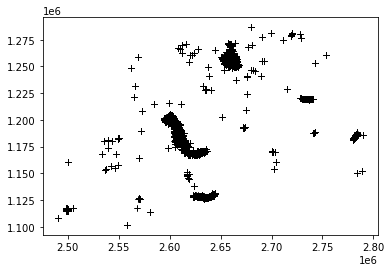

In [15]:
# Plot x-coordnates vs. y-coordinates 
%matplotlib inline

x = all_data['XCOORD']
y = all_data['YCOORD']

plt.plot(x, y, '+', color='black');

/Users/oesterli/anaconda3/envs/env02/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/oesterli/anaconda3/envs/env02/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([7.6853e+04, 3.0170e+03, 1.8670e+03, 1.7830e+03, 1.3940e+03,
        4.7700e+02, 0.0000e+00, 1.0400e+02, 1.8100e+02, 2.4000e+01]),
 array([8.00000e-01, 5.95220e+02, 1.18964e+03, 1.78406e+03, 2.37848e+03,
        2.97290e+03, 3.56732e+03, 4.16174e+03, 4.75616e+03, 5.35058e+03,
        5.94500e+03]),
 <a list of 10 Patch objects>)

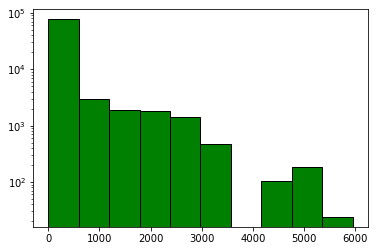

In [16]:
# Plot depth distribution of boreholes 
plt.hist(all_data['TIEFEMD'], label='TIEFEMD', log=True, histtype='bar', edgecolor='black',  color='green')

# Statistics
### Count unique boreholes and layers


In [17]:
# Create some simple statistics
num_bh = len(all_data['SHORTNAME'].unique())
num_layers = all_data.shape[0]
print('Number of individual borehole: ', num_bh)
print('Number of individual layers: ', num_layers)

# calculate number of layers per borehole
layer_per_bh = all_data.groupby('SHORTNAME')['DEPTHFROM'].nunique()
print(layer_per_bh.describe())

Number of individual borehole:  6060
Number of individual layers:  85822
count    6060.000000
mean       14.159076
std        17.686057
min         1.000000
25%         7.000000
50%        11.000000
75%        16.000000
max       400.000000
Name: DEPTHFROM, dtype: float64


# Preprocessing raw data
### Sort data

In [18]:
# Sort data by "SHORTNAME" and "DEPTHFROM"
all_data_sorted = all_data.sort_values(by=["SHORTNAME", "DEPTHFROM"])
print('Shape of data set: ', all_data_sorted.shape)
all_data_sorted[["SHORTNAME","RESTRICTIO", "DEPTHFROM", "DEPTHTO", "TIEFEMD"]].head(20)

Shape of data set:  (85822, 105)


,SHORTNAME,RESTRICTIO,DEPTHFROM,DEPTHTO,TIEFEMD
33957,003ITDQ900,f,0.00,2.00,136.0
33958,003ITDQ900,f,2.00,42.00,136.0
33959,003ITDQ900,f,42.00,136.00,136.0
84898,00B5DNQ900,g,0.00,0.10,17.0
84899,00B5DNQ900,g,0.10,0.50,17.0
84900,00B5DNQ900,g,0.50,2.85,17.0
84901,00B5DNQ900,g,2.85,13.30,17.0
84902,00B5DNQ900,g,13.30,17.00,17.0
52093,00HYTDQ900,g,0.00,0.20,18.5
52094,00HYTDQ900,g,0.20,2.10,18.5


### Create index

In [19]:
# Create an index column
all_data_sorted['index'] = all_data_sorted.index
print('Shape of data set: ', all_data_sorted.shape)
all_data_sorted[["index", "SHORTNAME","RESTRICTIO", "DEPTHFROM", "DEPTHTO", "TIEFEMD"]].head(20)

Shape of data set:  (85822, 106)


,index,SHORTNAME,RESTRICTIO,DEPTHFROM,DEPTHTO,TIEFEMD
33957,33957,003ITDQ900,f,0.00,2.00,136.0
33958,33958,003ITDQ900,f,2.00,42.00,136.0
33959,33959,003ITDQ900,f,42.00,136.00,136.0
84898,84898,00B5DNQ900,g,0.00,0.10,17.0
84899,84899,00B5DNQ900,g,0.10,0.50,17.0
84900,84900,00B5DNQ900,g,0.50,2.85,17.0
84901,84901,00B5DNQ900,g,2.85,13.30,17.0
84902,84902,00B5DNQ900,g,13.30,17.00,17.0
52093,52093,00HYTDQ900,g,0.00,0.20,18.5
52094,52094,00HYTDQ900,g,0.20,2.10,18.5


### Clean columns

In [20]:
# Round data
#df['DataFrame column'].round(decimals=number of decimal places needed)
all_data_sorted['XCOORD'] = all_data_sorted['XCOORD'].round(decimals=2)
all_data_sorted['YCOORD'] = all_data_sorted['YCOORD'].round(decimals=2)
all_data_sorted['ZCOORDB'] = all_data_sorted['ZCOORDB'].round(decimals=2)
all_data_sorted['TIEFEMD'] = all_data_sorted['TIEFEMD'].round(decimals=2)
all_data_sorted['DEPTHFROM'] = all_data_sorted['DEPTHFROM'].round(decimals=2)
all_data_sorted['DEPTHTO'] = all_data_sorted['DEPTHTO'].round(decimals=2)

In [21]:
# Check rounding
all_data_sorted[sel_cols].select_dtypes(include=['float64'])


,XCOORD,YCOORD,ZCOORDB,TIEFEMD,DEPTHFROM,DEPTHTO,LITHOSTRAT
33957,2618810.00,1169000.0,747.70,136.0,0.0,2.0,NaN
33958,2618810.00,1169000.0,747.70,136.0,2.0,42.0,NaN
33959,2618810.00,1169000.0,747.70,136.0,42.0,136.0,NaN
84898,2499908.79,1115080.1,387.12,17.0,0.0,0.1,NaN
84899,2499908.79,1115080.1,387.12,17.0,0.1,0.5,NaN
...,...,...,...,...,...,...,...
52542,2654905.00,1253230.0,349.80,12.0,0.8,3.2,NaN
52544,2654905.00,1253230.0,349.80,12.0,3.2,4.6,NaN
52545,2654905.00,1253230.0,349.80,12.0,4.6,5.0,NaN
52546,2654905.00,1253230.0,349.80,12.0,5.0,9.2,NaN


In [22]:
all_data_sorted.head()

,LONGNAME,XCOORD,YCOORD,ZCOORDB,ZCOORDE,SHORTNAME,PROJEKTNAM,ORIGNAME,BOHRTYP,NAMEPUB,...,INTART_1,INTKLASSE,COMMENTARY,ORIGGEOL,LAGEOQID,LETZTBEARB_2,BEARBDATUM_2,GEODINGUID_STLAYER,BOHREDAT_1,index
33957,Sondierung S1 - 003ITDQ900,2618810.00,1169000.0,747.70,0.0,003ITDQ900,GENER.GEOL.UNTERSUCHUNGEN F.ERDSONDENBOHRUNG B...,Sondierung S1,B,Sondierung S1,...,NaN,NaN,kA,Aufschüttung,NaN,U80825759,2019-11-26,{939c81ee-247e-4ed0-8a93-77bc6b3bc6de},1998-09-01,33957
33958,Sondierung S1 - 003ITDQ900,2618810.00,1169000.0,747.70,0.0,003ITDQ900,GENER.GEOL.UNTERSUCHUNGEN F.ERDSONDENBOHRUNG B...,Sondierung S1,B,Sondierung S1,...,NaN,NaN,kA,verschwemmte Moräne,NaN,U80825759,2019-11-26,{daf7468d-4ca8-46cb-b015-afbbe2fd1116},1998-09-01,33958
33959,Sondierung S1 - 003ITDQ900,2618810.00,1169000.0,747.70,0.0,003ITDQ900,GENER.GEOL.UNTERSUCHUNGEN F.ERDSONDENBOHRUNG B...,Sondierung S1,B,Sondierung S1,...,NaN,NaN,kA,Trias der Klippendecke,NaN,U80825759,2019-11-26,{8ab0d89f-4243-43ca-91c9-8c9801e0cb78},1998-09-01,33959
84898,S2-06 - 00B5DNQ900,2499908.79,1115080.1,387.12,0.0,00B5DNQ900,SIM.968,S2-06,B,S2-06,...,NaN,NaN,ka,Remblais,NaN,U80825759,2019-11-26,{026b2e48-3418-4a87-b65b-7f4107511ca8},2006-08-31,84898
84899,S2-06 - 00B5DNQ900,2499908.79,1115080.1,387.12,0.0,00B5DNQ900,SIM.968,S2-06,B,S2-06,...,NaN,NaN,ka,Remblais,NaN,U80825759,2019-11-26,{34272a25-f477-4f20-b4de-20eb79148e62},2006-08-31,84899


<font color=red><h1>
    Export raw data to file >>>>><a id="linkxy"></a></h1></font>

In [23]:
# Export all data to csv

bh_raw_file = '_'.join(['bh_raw', str(now), str(run_num).zfill(2),]) +'.csv'
bh_raw_path = os.path.join(out_dir_run,bh_raw_file)
all_data_sorted.to_csv(bh_raw_path,index=None, sep=';')

# Preprocessing PRIVATE data

### Catch all columns and column numbers in dict
This shall help to easily see which cloumn is mentioned in warnings

In [ ]:
#10,13,17,18,20,71,100

In [24]:
# copy all columns name to list "cols"
cols = all_data_sorted.columns.to_list()

# Create a dictionry of column names and locations
col_dicts = {}

keys = len(cols)
values = cols

for i in range(keys):
        col_dicts[i] = values[i]

print(col_dicts)


{0: 'LONGNAME', 1: 'XCOORD', 2: 'YCOORD', 3: 'ZCOORDB', 4: 'ZCOORDE', 5: 'SHORTNAME', 6: 'PROJEKTNAM', 7: 'ORIGNAME', 8: 'BOHRTYP', 9: 'NAMEPUB', 10: 'QCCOORDEN', 11: 'QCELEVATIZ', 12: 'TIEFEMD', 13: 'QCTIEFE', 14: 'BOHREDAT', 15: 'LAND', 16: 'KANTON', 17: 'GEMEINDE', 18: 'STRASSE', 19: 'RESTRICTIO', 20: 'RESTRICDAT', 21: 'BMETHOD', 22: 'BOHRGUT', 23: 'BOHRZWECK', 24: 'STATUSBOHR', 25: 'TOPBEDROCK', 26: 'QCTOPBED', 27: 'GROUNDWATE', 28: 'DIAMETER', 29: 'INKLINAT', 30: 'RICHTUNG', 31: 'QCINKRICHT', 32: 'LITTOPBED', 33: 'STRATOPDEB', 34: 'CHROTOPBED', 35: 'EPSG', 36: 'HRS', 37: 'ARTANSATZZ', 38: 'LANDNUTZNG', 39: 'BEARBSTATU', 40: 'GEOLDATBED', 41: 'ATTRIBEARB', 42: 'ANZSCHICHT', 43: 'BEMERKUNG', 44: 'FEHLER', 45: 'LETZTBEARB', 46: 'BEARBDATUM', 47: 'GEODINGUID_STGENER', 48: 'INTV', 49: 'INTART', 50: 'GRUND', 51: 'QCBOHRUNG', 52: 'LETZTBEARB_1', 53: 'BEARBDATUM_1', 54: 'BAUGRDKLAS', 55: 'GEODINGUID_STLYRTIT', 56: 'DEPTHFROM', 57: 'DEPTHTO', 58: 'LAYERDESC', 59: 'DESCRIPTIO', 60: 'BESCHRS

In [25]:
# Check the shape (rows, columns) of the combined files
all_data_sorted.shape

(85822, 106)

### Checking for duplicated rows  and eliminate them

In [26]:
# Create a list of columns except the index column, in order to use it as a subset for finding duplicate rows
cols_2 = cols[0:-1]

In [27]:
# Find duplicate rows (checking duplicates based on all columns)
dup_rows = all_data_sorted[all_data_sorted.duplicated(subset=cols_2)]
print("Duplicate Rows except first occurrence based on all columns are :", dup_rows['LONGNAME'].count())

#Show duplicate entries if exisiting
if len(dup_rows) > 0:
    dup_rows.head()
else:
    pass

Duplicate Rows except first occurrence based on all columns are : 0


In [28]:
# Drop all duplicated rows and save result to "all_data_unique"
if len(dup_rows) > 0:
    all_data_unique = all_data_sorted.drop_duplicates(subset=cols_2)
    print(len(dup_rows), " dropped")
    print("shape all_data_unipue: ", all_data_unique.shape)
    print("shape all_data_sorted: ", all_data_sorted.shape)
else:
    all_data_unique = all_data_sorted
    print("No rows dropped")
    #print("shape all_data_unipue: ", all_data_unique.shape)
    print("shape all_data_sorted: ", all_data_sorted.shape)

No rows dropped
shape all_data_sorted:  (85822, 106)


### Select relevant columns
Columns are defined in section ["Configuration"](#linkConfig)

In [29]:
# Select only relevant columns and save into "all_data_unique_sel"
all_data_unique_sel = all_data_unique[sel_cols]

# For entire data set with all columns: Save all into "all_data_unique_sel"
#all_data_unique_sel = all_data_unique


In [30]:
all_data_unique_sel.head(5)

,index,XCOORD,YCOORD,ZCOORDB,ORIGNAME,NAMEPUB,SHORTNAME,BOHREDAT,BOHRTYP,GRUND,...,DEPTHTO,LAYERDESC,ORIGGEOL,LITHOLOGY,LITHOSTRAT,CHRONOSTR,TECTO,USCS1,USCS2,USCS3
33957,33957,2618810.00,1169000.0,747.70,Sondierung S1,Sondierung S1,003ITDQ900,1998-09-01,B,geoquat,...,2.0,Aufschüttung: kiesig - sandiger Lehm,Aufschüttung,NaN,NaN,NaN,NaN,ml,s,g
33958,33958,2618810.00,1169000.0,747.70,Sondierung S1,Sondierung S1,003ITDQ900,1998-09-01,B,geoquat,...,42.0,"Sehr sandiger Kies (FS - CS, Durchmesser 2 - 6...",verschwemmte Moräne,NaN,NaN,NaN,NaN,g-gm,sw,bl
33959,33959,2618810.00,1169000.0,747.70,Sondierung S1,Sondierung S1,003ITDQ900,1998-09-01,B,geoquat,...,136.0,"± toniger Kalk, schwarzgrau",Trias der Klippendecke,NaN,NaN,NaN,NaN,fels,ka,ka
84898,84898,2499908.79,1115080.1,387.12,S2-06,S2-06,00B5DNQ900,2006-08-31,B,geoquat,...,0.1,Bitume.,Remblais,NaN,NaN,NaN,NaN,kunst,ka,ka
84899,84899,2499908.79,1115080.1,387.12,S2-06,S2-06,00B5DNQ900,2006-08-31,B,geoquat,...,0.5,Gravier sableux.,Remblais,NaN,NaN,NaN,NaN,g,s,ka


# <font color='red'> > Create GDF for all data PRIVATE data</font>

In [31]:
# Convert dataframe "all_data_unique_sel" to geodataframe "gdf" and set inital crs to epsg:2056 
geom = [Point(xy) for xy in zip(all_data_unique_sel.XCOORD, all_data_unique_sel.YCOORD)]
crs = {"init" : "epsg:2056"}
private_bh = gpd.GeoDataFrame(all_data_unique_sel, crs=crs, geometry=geom)

/Users/oesterli/anaconda3/envs/env02/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [32]:
# Check gdf
private_bh.head()
#private_bh.shape

,index,XCOORD,YCOORD,ZCOORDB,ORIGNAME,NAMEPUB,SHORTNAME,BOHREDAT,BOHRTYP,GRUND,...,LAYERDESC,ORIGGEOL,LITHOLOGY,LITHOSTRAT,CHRONOSTR,TECTO,USCS1,USCS2,USCS3,geometry
33957,33957,2618810.00,1169000.0,747.70,Sondierung S1,Sondierung S1,003ITDQ900,1998-09-01,B,geoquat,...,Aufschüttung: kiesig - sandiger Lehm,Aufschüttung,NaN,NaN,NaN,NaN,ml,s,g,POINT (2618810.000 1169000.000)
33958,33958,2618810.00,1169000.0,747.70,Sondierung S1,Sondierung S1,003ITDQ900,1998-09-01,B,geoquat,...,"Sehr sandiger Kies (FS - CS, Durchmesser 2 - 6...",verschwemmte Moräne,NaN,NaN,NaN,NaN,g-gm,sw,bl,POINT (2618810.000 1169000.000)
33959,33959,2618810.00,1169000.0,747.70,Sondierung S1,Sondierung S1,003ITDQ900,1998-09-01,B,geoquat,...,"± toniger Kalk, schwarzgrau",Trias der Klippendecke,NaN,NaN,NaN,NaN,fels,ka,ka,POINT (2618810.000 1169000.000)
84898,84898,2499908.79,1115080.1,387.12,S2-06,S2-06,00B5DNQ900,2006-08-31,B,geoquat,...,Bitume.,Remblais,NaN,NaN,NaN,NaN,kunst,ka,ka,POINT (2499908.790 1115080.100)
84899,84899,2499908.79,1115080.1,387.12,S2-06,S2-06,00B5DNQ900,2006-08-31,B,geoquat,...,Gravier sableux.,Remblais,NaN,NaN,NaN,NaN,g,s,ka,POINT (2499908.790 1115080.100)


# Plot GDF

In [33]:
# Load swiss boundary from shapefile
ch_perimeter = gpd.read_file('./data/input/helper/swissBOUNDARIES3D_1_3_TLM_LANDESGEBIET.shp')

In [34]:
# Select only swiss perimeter
ch_perimeter = ch_perimeter[ch_perimeter['ICC'] == 'CH']
ch_perimeter

,UUID,DATUM_AEND,DATUM_ERST,ERSTELL_J,ERSTELL_M,REVISION_J,REVISION_M,GRUND_AEND,HERKUNFT,HERKUNFT_J,HERKUNFT_M,OBJEKTART,REVISION_Q,ICC,SEE_FLAECH,NAME,EINWOHNERZ,LANDESFLAE,LAND_TEIL,geometry
0,{B347A0FB-1DB1-42CE-8F76-D95FD4786266},2018-11-22,2012-10-26,2012,10,2020,10,Verbessert,AV,2019,1,Land,2019_Aufbau,CH,129858.0,Schweiz,8544527,4129069.0,0,"POLYGON Z ((2758297.125 1237629.497 427.413, 2..."


In [35]:
# Create buffer around CH-Perimeter
ch_peri_buf_10km = ch_perimeter.buffer(20000) # 20km

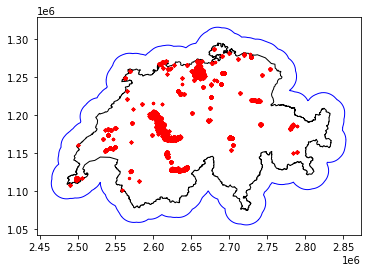

In [36]:
# Plot GeoDataFrame together with swiss boundary 
base = ch_perimeter.plot(color='white', edgecolor='black')
lyr_1 = ch_peri_buf_10km.plot(ax=base, edgecolor='blue', facecolor='none')
private_bh.plot(ax=lyr_1, color='red', markersize=5);

### CLIP GDF to swiss boundary

In [ ]:
# Clip the data using GeoPandas clip
gdf_clip = gpd.clip(gdf, ch_perimeter)

### Reproject EPSG:2056 to EPSG:4326

In [37]:
#Write re-projected coordinates into new column
#gdf_trans = gdf
private_bh["geom4326"] = private_bh["geometry"].to_crs("epsg:4326")

private_bh["x4326"] = private_bh["geom4326"].apply(lambda p: p.x)
private_bh["y4326"] = private_bh["geom4326"].apply(lambda p: p.y)

private_bh.shape

(85822, 27)

In [38]:
private_bh.head()

,index,XCOORD,YCOORD,ZCOORDB,ORIGNAME,NAMEPUB,SHORTNAME,BOHREDAT,BOHRTYP,GRUND,...,LITHOSTRAT,CHRONOSTR,TECTO,USCS1,USCS2,USCS3,geometry,geom4326,x4326,y4326
33957,33957,2618810.00,1169000.0,747.70,Sondierung S1,Sondierung S1,003ITDQ900,1998-09-01,B,geoquat,...,NaN,NaN,NaN,ml,s,g,POINT (2618810.000 1169000.000),POINT (7.68445 46.67196),7.684450,46.671964
33958,33958,2618810.00,1169000.0,747.70,Sondierung S1,Sondierung S1,003ITDQ900,1998-09-01,B,geoquat,...,NaN,NaN,NaN,g-gm,sw,bl,POINT (2618810.000 1169000.000),POINT (7.68445 46.67196),7.684450,46.671964
33959,33959,2618810.00,1169000.0,747.70,Sondierung S1,Sondierung S1,003ITDQ900,1998-09-01,B,geoquat,...,NaN,NaN,NaN,fels,ka,ka,POINT (2618810.000 1169000.000),POINT (7.68445 46.67196),7.684450,46.671964
84898,84898,2499908.79,1115080.1,387.12,S2-06,S2-06,00B5DNQ900,2006-08-31,B,geoquat,...,NaN,NaN,NaN,kunst,ka,ka,POINT (2499908.790 1115080.100),POINT (6.14240 46.17973),6.142399,46.179731
84899,84899,2499908.79,1115080.1,387.12,S2-06,S2-06,00B5DNQ900,2006-08-31,B,geoquat,...,NaN,NaN,NaN,g,s,ka,POINT (2499908.790 1115080.100),POINT (6.14240 46.17973),6.142399,46.179731


In [39]:
private_bh.shape

(85822, 27)

In [40]:
# Rename columns according to conventions
private_bh.columns = export_pri_cols
private_bh.head()

,bh_pri_index,bh_pri_XCOORD,bh_pri_YCOORD,bh_pri_ZCOORDB,bh_pri_ORIGNAME,bh_pri_NAMEPUB,bh_pri_SHORTNAME,bh_pri_BOHREDAT,bh_pri_BOHRTYP,bh_pri_GRUND,...,bh_pri_LITHOSTRAT,bh_pri_CHRONOSTR,bh_pri_TECTO,bh_pri_USCS1,bh_pri_USCS2,bh_pri_USCS3,bh_pri_geometry,bh_pri_geom4326,bh_pri_x4326,bh_pri_y4326
33957,33957,2618810.00,1169000.0,747.70,Sondierung S1,Sondierung S1,003ITDQ900,1998-09-01,B,geoquat,...,NaN,NaN,NaN,ml,s,g,POINT (2618810.000 1169000.000),POINT (7.68445 46.67196),7.684450,46.671964
33958,33958,2618810.00,1169000.0,747.70,Sondierung S1,Sondierung S1,003ITDQ900,1998-09-01,B,geoquat,...,NaN,NaN,NaN,g-gm,sw,bl,POINT (2618810.000 1169000.000),POINT (7.68445 46.67196),7.684450,46.671964
33959,33959,2618810.00,1169000.0,747.70,Sondierung S1,Sondierung S1,003ITDQ900,1998-09-01,B,geoquat,...,NaN,NaN,NaN,fels,ka,ka,POINT (2618810.000 1169000.000),POINT (7.68445 46.67196),7.684450,46.671964
84898,84898,2499908.79,1115080.1,387.12,S2-06,S2-06,00B5DNQ900,2006-08-31,B,geoquat,...,NaN,NaN,NaN,kunst,ka,ka,POINT (2499908.790 1115080.100),POINT (6.14240 46.17973),6.142399,46.179731
84899,84899,2499908.79,1115080.1,387.12,S2-06,S2-06,00B5DNQ900,2006-08-31,B,geoquat,...,NaN,NaN,NaN,g,s,ka,POINT (2499908.790 1115080.100),POINT (6.14240 46.17973),6.142399,46.179731


### Use private_bh as basis for creating OPEN data set and 2D data set

# <font color='red'> Export PRIVATE data to file >>>>> </font>

In [41]:
# Export PRIVATE data to csv
#all_data_sorted.to_csv("./data/output/Schichtdaten/bh_raw_201109.csv",index=None)
bh_private_file = '_'.join(['bh_private', str(now), str(run_num).zfill(2),]) +'.csv'
bh_private_path = os.path.join(out_dir_run,bh_private_file)
private_bh.to_csv(bh_private_path,index=None, sep=';')

# Preprocessing data for OPEN dataset
### Introduce columns "start" and "end" to to store start and end depth of entire borehole to each row 

In [42]:
# Reset columns names to original
private_bh.columns = cols_pub
private_bh.head()

,index,XCOORD,YCOORD,ZCOORDB,ORIGNAME,NAMEPUB,SHORTNAME,BOHREDAT,BOHRTYP,GRUND,...,LITHOSTRAT,CHRONOSTR,TECTO,USCS1,USCS2,USCS3,geometry,geom4326,x4326,y4326
33957,33957,2618810.00,1169000.0,747.70,Sondierung S1,Sondierung S1,003ITDQ900,1998-09-01,B,geoquat,...,NaN,NaN,NaN,ml,s,g,POINT (2618810.000 1169000.000),POINT (7.68445 46.67196),7.684450,46.671964
33958,33958,2618810.00,1169000.0,747.70,Sondierung S1,Sondierung S1,003ITDQ900,1998-09-01,B,geoquat,...,NaN,NaN,NaN,g-gm,sw,bl,POINT (2618810.000 1169000.000),POINT (7.68445 46.67196),7.684450,46.671964
33959,33959,2618810.00,1169000.0,747.70,Sondierung S1,Sondierung S1,003ITDQ900,1998-09-01,B,geoquat,...,NaN,NaN,NaN,fels,ka,ka,POINT (2618810.000 1169000.000),POINT (7.68445 46.67196),7.684450,46.671964
84898,84898,2499908.79,1115080.1,387.12,S2-06,S2-06,00B5DNQ900,2006-08-31,B,geoquat,...,NaN,NaN,NaN,kunst,ka,ka,POINT (2499908.790 1115080.100),POINT (6.14240 46.17973),6.142399,46.179731
84899,84899,2499908.79,1115080.1,387.12,S2-06,S2-06,00B5DNQ900,2006-08-31,B,geoquat,...,NaN,NaN,NaN,g,s,ka,POINT (2499908.790 1115080.100),POINT (6.14240 46.17973),6.142399,46.179731


In [43]:
private_bh.shape

(85822, 27)

In [44]:
# create new columns "start" and "end" and fill it with start and end depth
private_bh['start'] = private_bh.groupby('SHORTNAME')['DEPTHFROM'].transform('min')
private_bh['end'] = private_bh.groupby('SHORTNAME')['DEPTHTO'].transform('max')

# show head
private_bh.sort_values(by=["SHORTNAME", "DEPTHFROM"]).head(10)


,index,XCOORD,YCOORD,ZCOORDB,ORIGNAME,NAMEPUB,SHORTNAME,BOHREDAT,BOHRTYP,GRUND,...,TECTO,USCS1,USCS2,USCS3,geometry,geom4326,x4326,y4326,start,end
33957,33957,2618810.00,1169000.0,747.70,Sondierung S1,Sondierung S1,003ITDQ900,1998-09-01,B,geoquat,...,NaN,ml,s,g,POINT (2618810.000 1169000.000),POINT (7.68445 46.67196),7.684450,46.671964,0.0,136.0
33958,33958,2618810.00,1169000.0,747.70,Sondierung S1,Sondierung S1,003ITDQ900,1998-09-01,B,geoquat,...,NaN,g-gm,sw,bl,POINT (2618810.000 1169000.000),POINT (7.68445 46.67196),7.684450,46.671964,0.0,136.0
33959,33959,2618810.00,1169000.0,747.70,Sondierung S1,Sondierung S1,003ITDQ900,1998-09-01,B,geoquat,...,NaN,fels,ka,ka,POINT (2618810.000 1169000.000),POINT (7.68445 46.67196),7.684450,46.671964,0.0,136.0
84898,84898,2499908.79,1115080.1,387.12,S2-06,S2-06,00B5DNQ900,2006-08-31,B,geoquat,...,NaN,kunst,ka,ka,POINT (2499908.790 1115080.100),POINT (6.14240 46.17973),6.142399,46.179731,0.0,17.0
84899,84899,2499908.79,1115080.1,387.12,S2-06,S2-06,00B5DNQ900,2006-08-31,B,geoquat,...,NaN,g,s,ka,POINT (2499908.790 1115080.100),POINT (6.14240 46.17973),6.142399,46.179731,0.0,17.0
84900,84900,2499908.79,1115080.1,387.12,S2-06,S2-06,00B5DNQ900,2006-08-31,B,geoquat,...,NaN,ml,st,ka,POINT (2499908.790 1115080.100),POINT (6.14240 46.17973),6.142399,46.179731,0.0,17.0
84901,84901,2499908.79,1115080.1,387.12,S2-06,S2-06,00B5DNQ900,2006-08-31,B,geoquat,...,NaN,gm,s,ka,POINT (2499908.790 1115080.100),POINT (6.14240 46.17973),6.142399,46.179731,0.0,17.0
84902,84902,2499908.79,1115080.1,387.12,S2-06,S2-06,00B5DNQ900,2006-08-31,B,geoquat,...,NaN,gp,s,ka,POINT (2499908.790 1115080.100),POINT (6.14240 46.17973),6.142399,46.179731,0.0,17.0
52093,52093,2658501.00,1255973.0,384.02,Sondierbohrung 56b,Sondierbohrung 56b,00HYTDQ900,1965-07-01,B,geoquat,...,NaN,s,g,ka,POINT (2658501.000 1255973.000),POINT (8.21435 47.45194),8.214349,47.451944,0.0,18.5
52094,52094,2658501.00,1255973.0,384.02,Sondierbohrung 56b,Sondierbohrung 56b,00HYTDQ900,1965-07-01,B,geoquat,...,NaN,sc,g,ka,POINT (2658501.000 1255973.000),POINT (8.21435 47.45194),8.214349,47.451944,0.0,18.5


### Split layer based on restriction level
Restriction level:
* g = restricted
* b = restricted until date specified
* f = free, not restricted

In [45]:
# Select row which have "RESTRICTIO" == "g"
# Select row which have "RESTRICTIO" == "f"
# Select row which have "RESTRICTIO" == "b"

df_g = private_bh.loc[private_bh["RESTRICTIO"] == "g"].sort_values(by=["SHORTNAME", "DEPTHFROM"])
df_f = private_bh.loc[private_bh["RESTRICTIO"] == "f"].sort_values(by=["SHORTNAME", "DEPTHFROM"])
df_b = private_bh.loc[private_bh["RESTRICTIO"] == "b"].sort_values(by=["SHORTNAME", "DEPTHFROM"])

# Sum of all rows from df_g, df_b, df_f
df_sum = df_g.shape[0] + df_b.shape[0] + df_f.shape[0]

print("All unique data: ",private_bh.shape)
print("Restricted unique data: ", df_g.shape)
print("Restricted until unique data: ", df_b.shape)
print("Non-restricted unique data: ", df_f.shape)
print("Restricted + restircted until + Non-restricted data: ", df_sum)
print("Difference between all unique data and restriceted + Non-restricted: ", private_bh.shape[0] - df_sum)


All unique data:  (85822, 29)
Restricted unique data:  (57706, 29)
Restricted until unique data:  (10, 29)
Non-restricted unique data:  (28106, 29)
Restricted + restircted until + Non-restricted data:  85822
Difference between all unique data and restriceted + Non-restricted:  0


In [46]:
# delete duplicates in df_g
df_g_unique = private_bh.loc[private_bh["RESTRICTIO"] == "g"].sort_values(by=["SHORTNAME", "DEPTHFROM"]).drop_duplicates("SHORTNAME")
print('df_g_unique: ', df_g_unique.shape)

# delete duplicates in df_b
df_b_unique = private_bh.loc[private_bh["RESTRICTIO"] == "b"].sort_values(by=["SHORTNAME", "DEPTHFROM"]).drop_duplicates("SHORTNAME")
print('df_b_unique: ', df_b_unique.shape)


df_g_unique:  (3865, 29)
df_b_unique:  (1, 29)


In [47]:
df_g_unique.head()

,index,XCOORD,YCOORD,ZCOORDB,ORIGNAME,NAMEPUB,SHORTNAME,BOHREDAT,BOHRTYP,GRUND,...,TECTO,USCS1,USCS2,USCS3,geometry,geom4326,x4326,y4326,start,end
84898,84898,2499908.79,1115080.1,387.12,S2-06,S2-06,00B5DNQ900,2006-08-31,B,geoquat,...,NaN,kunst,ka,ka,POINT (2499908.790 1115080.100),POINT (6.14240 46.17973),6.142399,46.179731,0.0,17.0
52093,52093,2658501.00,1255973.0,384.02,Sondierbohrung 56b,Sondierbohrung 56b,00HYTDQ900,1965-07-01,B,geoquat,...,NaN,s,g,ka,POINT (2658501.000 1255973.000),POINT (8.21435 47.45194),8.214349,47.451944,0.0,18.5
29000,29000,2595348.00,1201670.0,504.05,RB1,RB1,01CCTDQ900,1970-04-01,B,geoquat,...,NaN,ol,sp-sm,st,POINT (2595348.000 1201670.000),POINT (7.37751 46.96609),7.377506,46.966088,0.0,21.6
60187,60187,2660071.00,1259047.0,372.64,Sondierbohrung No. 4,Sondierbohrung No. 4,01NCDNQ900,1970-06-19,B,geoquat,...,NaN,g,sm,st,POINT (2660071.000 1259047.000),POINT (8.23558 47.47945),8.235580,47.479449,0.0,26.0
59008,59008,2661469.00,1264163.0,481.24,Baugrundsondierung 2B,Baugrundsondierung 2B,01QNCNQ900,1974-04-23,B,geoquat,...,NaN,ol,ka,ka,POINT (2661469.000 1264163.000),POINT (8.25483 47.52533),8.254832,47.525330,0.0,5.0


In [48]:
# Append df_b to df_g, so that all restriced data are in one dataframe
df_g_unique = df_g_unique.append(df_b_unique)

In [49]:
df_g_unique.shape

(3866, 29)

### Replace layer details with undefined values

In [50]:
# Overwrite "DEPTHFROM" and "DEPTHTO" with "start" and "end", respectively
df_g_unique["DEPTHFROM"] = df_g_unique["start"]
df_g_unique["DEPTHTO"] = df_g_unique["end"]

# Overwrite "LAYERDESC" of restricted boreholes ("RESTRICTIO = "g) with "Undefined"
df_g_unique[["LAYERDESC", "ORIGGEOL", "ORIGNAME", "BOHRTYP", "CHRONOSTR", "LITHOLOGY", "LITHOSTRAT"]] = "Undefined"

### Combine free and restricted data into one

In [51]:
# Combine the two dataframe df_g and df_f
frames = [df_g_unique, df_f]
open_bh = pd.concat(frames)

# Drop the columns "start" and "end"
open_bh = open_bh.drop(["start", "end"], axis=1)


In [52]:
# Sort dataset by unique-ID "SHORTNAME" and "DEPTHFROM"
open_bh = open_bh.sort_values(by=["SHORTNAME", "DEPTHFROM"])

In [53]:
open_bh.shape

(31972, 27)

In [54]:
open_bh['SHORTNAME'].nunique()

6060

In [55]:
open_bh.columns = export_pub_cols
open_bh.head()

,bh_pub_index,bh_pub_XCOORD,bh_pub_YCOORD,bh_pub_ZCOORDB,bh_pub_ORIGNAME,bh_pub_NAMEPUB,bh_pub_SHORTNAME,bh_pub_BOHREDAT,bh_pub_BOHRTYP,bh_pub_GRUND,...,bh_pub_LITHOSTRAT,bh_pub_CHRONOSTR,bh_pub_TECTO,bh_pub_USCS1,bh_pub_USCS2,bh_pub_USCS3,bh_pub_geometry,bh_pub_geom4326,bh_pub_x4326,bh_pub_y4326
33957,33957,2618810.00,1169000.0,747.70,Sondierung S1,Sondierung S1,003ITDQ900,1998-09-01,B,geoquat,...,NaN,NaN,NaN,ml,s,g,POINT (2618810.000 1169000.000),POINT (7.68445 46.67196),7.684450,46.671964
33958,33958,2618810.00,1169000.0,747.70,Sondierung S1,Sondierung S1,003ITDQ900,1998-09-01,B,geoquat,...,NaN,NaN,NaN,g-gm,sw,bl,POINT (2618810.000 1169000.000),POINT (7.68445 46.67196),7.684450,46.671964
33959,33959,2618810.00,1169000.0,747.70,Sondierung S1,Sondierung S1,003ITDQ900,1998-09-01,B,geoquat,...,NaN,NaN,NaN,fels,ka,ka,POINT (2618810.000 1169000.000),POINT (7.68445 46.67196),7.684450,46.671964
84898,84898,2499908.79,1115080.1,387.12,Undefined,S2-06,00B5DNQ900,2006-08-31,Undefined,geoquat,...,Undefined,Undefined,NaN,kunst,ka,ka,POINT (2499908.790 1115080.100),POINT (6.14240 46.17973),6.142399,46.179731
52093,52093,2658501.00,1255973.0,384.02,Undefined,Sondierbohrung 56b,00HYTDQ900,1965-07-01,Undefined,geoquat,...,Undefined,Undefined,NaN,s,g,ka,POINT (2658501.000 1255973.000),POINT (8.21435 47.45194),8.214349,47.451944


# <font color='red'> Export OPEN data </font>

In [56]:
# Export PRIVATE data to csv
#all_data_sorted.to_csv("./data/output/Schichtdaten/bh_raw_201109.csv",index=None)
bh_open_file = '_'.join(['bh_open', str(now), str(run_num).zfill(2),]) +'.csv'
bh_open_path = os.path.join(out_dir_run,bh_open_file)
open_bh.to_csv(bh_open_path,index=None, sep=';')

# Prepocessing 2D Data
### Create 2D data set by aggregating records by "SHORTNAME", each record becomes one borehole

In [57]:
# Reset columns names to orginal
open_bh.columns = cols_pub
open_bh.head()

,index,XCOORD,YCOORD,ZCOORDB,ORIGNAME,NAMEPUB,SHORTNAME,BOHREDAT,BOHRTYP,GRUND,...,LITHOSTRAT,CHRONOSTR,TECTO,USCS1,USCS2,USCS3,geometry,geom4326,x4326,y4326
33957,33957,2618810.00,1169000.0,747.70,Sondierung S1,Sondierung S1,003ITDQ900,1998-09-01,B,geoquat,...,NaN,NaN,NaN,ml,s,g,POINT (2618810.000 1169000.000),POINT (7.68445 46.67196),7.684450,46.671964
33958,33958,2618810.00,1169000.0,747.70,Sondierung S1,Sondierung S1,003ITDQ900,1998-09-01,B,geoquat,...,NaN,NaN,NaN,g-gm,sw,bl,POINT (2618810.000 1169000.000),POINT (7.68445 46.67196),7.684450,46.671964
33959,33959,2618810.00,1169000.0,747.70,Sondierung S1,Sondierung S1,003ITDQ900,1998-09-01,B,geoquat,...,NaN,NaN,NaN,fels,ka,ka,POINT (2618810.000 1169000.000),POINT (7.68445 46.67196),7.684450,46.671964
84898,84898,2499908.79,1115080.1,387.12,Undefined,S2-06,00B5DNQ900,2006-08-31,Undefined,geoquat,...,Undefined,Undefined,NaN,kunst,ka,ka,POINT (2499908.790 1115080.100),POINT (6.14240 46.17973),6.142399,46.179731
52093,52093,2658501.00,1255973.0,384.02,Undefined,Sondierbohrung 56b,00HYTDQ900,1965-07-01,Undefined,geoquat,...,Undefined,Undefined,NaN,s,g,ka,POINT (2658501.000 1255973.000),POINT (8.21435 47.45194),8.214349,47.451944


In [58]:
# Drop all duplicated record based on unique-ID "SHORTNAME" apart from first record

bh_2d = open_bh.drop_duplicates(subset=["SHORTNAME"], keep="first")

In [59]:
bh_2d.shape

(6060, 27)

In [60]:
bh_2d.head()

,index,XCOORD,YCOORD,ZCOORDB,ORIGNAME,NAMEPUB,SHORTNAME,BOHREDAT,BOHRTYP,GRUND,...,LITHOSTRAT,CHRONOSTR,TECTO,USCS1,USCS2,USCS3,geometry,geom4326,x4326,y4326
33957,33957,2618810.00,1169000.0,747.70,Sondierung S1,Sondierung S1,003ITDQ900,1998-09-01,B,geoquat,...,NaN,NaN,NaN,ml,s,g,POINT (2618810.000 1169000.000),POINT (7.68445 46.67196),7.684450,46.671964
84898,84898,2499908.79,1115080.1,387.12,Undefined,S2-06,00B5DNQ900,2006-08-31,Undefined,geoquat,...,Undefined,Undefined,NaN,kunst,ka,ka,POINT (2499908.790 1115080.100),POINT (6.14240 46.17973),6.142399,46.179731
52093,52093,2658501.00,1255973.0,384.02,Undefined,Sondierbohrung 56b,00HYTDQ900,1965-07-01,Undefined,geoquat,...,Undefined,Undefined,NaN,s,g,ka,POINT (2658501.000 1255973.000),POINT (8.21435 47.45194),8.214349,47.451944
22416,22416,2602457.00,1200646.0,562.30,SB 2,SB 2,01C4TDQ900,1989-04-14,B,geoquat,...,NaN,NaN,NaN,g,ka,ka,POINT (2602457.000 1200646.000),POINT (7.47091 46.95689),7.470911,46.956889
29000,29000,2595348.00,1201670.0,504.05,Undefined,RB1,01CCTDQ900,1970-04-01,Undefined,geoquat,...,Undefined,Undefined,NaN,ol,sp-sm,st,POINT (2595348.000 1201670.000),POINT (7.37751 46.96609),7.377506,46.966088


### Select only relevant columns for 2D dataset

In [61]:
# Select only relvant columns and save it back into "df_all_unique"
#df_all_unique = df_all_unique[["index","XCOORD","YCOORD","ZCOORDB","ORIGNAME","NAMEPUB","SHORTNAME", 'BOHREDAT',"BOHRTYP", 'GRUND',"RESTRICTIO","TIEFEMD"]]
bh_2d = bh_2d[cols_2D]


### Create new Atribute for Link to swissgeol

In [62]:
#Define parameter 
baseURL = 'https://swissgeol.ch/?'
para_sep = '&'

layer_key = 'layers='
layer_value = 'boreholes'

layer_vis = 'layers_visibility='
layer_vis_value = 'true'

layer_trans = 'layers_transparency='
layer_trans_value = '0'
link_key = 'zoom_to='
link_sep = ','

# create Link
#df_all_unique['link'] = baseURL + layer_key + layer_value + para_sep + layer_vis + layer_vis_value + para_sep + layer_trans + layer_trans_value + para_sep + link_key + df_all_unique['x4326'].map(str) + link_sep + df_all_unique['y4326'].map(str) +  link_sep + df_all_unique['ZCOORDB'].map(str)
bh_2d['link'] = baseURL + layer_key + layer_value + para_sep + layer_vis + layer_vis_value + para_sep + layer_trans + layer_trans_value + para_sep + link_key + bh_2d['x4326'].map(str) + link_sep + bh_2d['y4326'].map(str) +  link_sep + '0'

bh_2d.head(5)



,index,XCOORD,YCOORD,x4326,y4326,ZCOORDB,ORIGNAME,NAMEPUB,SHORTNAME,BOHREDAT,BOHRTYP,GRUND,RESTRICTIO,TIEFEMD,link
33957,33957,2618810.00,1169000.0,7.684450,46.671964,747.70,Sondierung S1,Sondierung S1,003ITDQ900,1998-09-01,B,geoquat,f,136.0,https://swissgeol.ch/?layers=boreholes&layers_...
84898,84898,2499908.79,1115080.1,6.142399,46.179731,387.12,Undefined,S2-06,00B5DNQ900,2006-08-31,Undefined,geoquat,g,17.0,https://swissgeol.ch/?layers=boreholes&layers_...
52093,52093,2658501.00,1255973.0,8.214349,47.451944,384.02,Undefined,Sondierbohrung 56b,00HYTDQ900,1965-07-01,Undefined,geoquat,g,18.5,https://swissgeol.ch/?layers=boreholes&layers_...
22416,22416,2602457.00,1200646.0,7.470911,46.956889,562.30,SB 2,SB 2,01C4TDQ900,1989-04-14,B,geoquat,f,8.3,https://swissgeol.ch/?layers=boreholes&layers_...
29000,29000,2595348.00,1201670.0,7.377506,46.966088,504.05,Undefined,RB1,01CCTDQ900,1970-04-01,Undefined,geoquat,g,21.6,https://swissgeol.ch/?layers=boreholes&layers_...


In [63]:
print(bh_2d['link'][0])

https://swissgeol.ch/?layers=boreholes&layers_visibility=true&layers_transparency=0&zoom_to=7.887782930737613,46.30095418940991,0


In [64]:
#sort how many unique record are in the dataset

bh_2d = bh_2d.sort_values(by=["SHORTNAME"])
bh_2d.shape

(6060, 15)

# <font color='red'> Export 2D data </font>

In [65]:
# Export PRIVATE data to csv

bh_2d_file = '_'.join(['bh_2D', str(now), str(run_num).zfill(2),]) +'.csv'
bh_2d_path = os.path.join(out_dir_run,bh_2d_file)
bh_2d.to_csv(bh_2d_path,index=None)